## 📌 **Author**

* Name: **MUHAMMED FIYAS**  
* Roll no.: **DA25M018**  
* *M.Tech DS&AI, IIT Madras*

---

# 📊 **DA5401 Assignment 7 – Multi-Class Model Selection using ROC and Precision–Recall Curves**

This project focuses on evaluating multiple machine learning classifiers for a **multi-class satellite image classification** problem using the **UCI Landsat Satellite dataset**.  
The analysis emphasizes **Receiver Operating Characteristic (ROC)** and **Precision–Recall Curve (PRC)** techniques to identify the most effective model beyond simple accuracy metrics.

---

## 🎯 **Objective**

The goal of this assignment is to perform **model selection** by analyzing classifier performance across different thresholds using **ROC-AUC** and **PRC-AP** metrics in a multi-class setting.

## **Part A: Data Preparation and Baseline**

In this section, we will:
1. Load and prepare the Landsat Satellite dataset
2. Standardize features for optimal model performance
3. Train 9 different classifiers on the training data
4. Evaluate baseline performance using Overall Accuracy and Weighted F1-Score

This baseline evaluation will help us identify which models perform well and which perform poorly before we dive into detailed ROC and Precision-Recall analysis.

In [34]:
import warnings
warnings.filterwarnings("ignore", message="Could not find the number of physical cores")

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

# Model imports
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# For reproducibility
import random
np.random.seed(42)
random.seed(42)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8-darkgrid')

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


### **Step 1: Load and Prepare Data**

**Task:** Load the Landsat Satellite dataset from the provided training and test files.

**Dataset Structure:**
- **Features:** 36 attributes representing multi-spectral values (4 spectral bands × 9 pixels in 3×3 neighborhood)
- **Target:** Class labels (1, 2, 3, 4, 5, 7) representing different land cover types:
  - 1: Red soil
  - 2: Cotton crop
  - 3: Grey soil
  - 4: Damp grey soil
  - 5: Soil with vegetation stubble
  - 7: Very damp grey soil

**Note:** Class 6 (mixture class) has been removed from the dataset.

In [6]:
# Load the training and test datasets
# The files are space-separated with no header
# Last column is the target class

train_data = pd.read_csv('sat.trn', sep=' ', header=None)
test_data = pd.read_csv('sat.tst', sep=' ', header=None)

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")
print(f"\nFirst few rows of training data:")
train_data.head()

Training data shape: (4435, 37)
Test data shape: (2000, 37)

First few rows of training data:


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
0,92,115,120,94,84,102,106,79,84,102,102,83,101,126,133,103,92,112,118,85,84,103,104,81,102,126,134,104,88,121,128,100,84,107,113,87,3
1,84,102,106,79,84,102,102,83,80,102,102,79,92,112,118,85,84,103,104,81,84,99,104,78,88,121,128,100,84,107,113,87,84,99,104,79,3
2,84,102,102,83,80,102,102,79,84,94,102,79,84,103,104,81,84,99,104,78,84,99,104,81,84,107,113,87,84,99,104,79,84,99,104,79,3
3,80,102,102,79,84,94,102,79,80,94,98,76,84,99,104,78,84,99,104,81,76,99,104,81,84,99,104,79,84,99,104,79,84,103,104,79,3
4,84,94,102,79,80,94,98,76,80,102,102,79,84,99,104,81,76,99,104,81,76,99,108,85,84,99,104,79,84,103,104,79,79,107,109,87,3


### Data Inspection and Feature-Target Separation

We'll separate the features (X) from the target labels (y) and verify the class distribution.

In [7]:
# Separate features and target
# The last column (column 36) is the target
X_train = train_data.iloc[:, :-1].values
y_train = train_data.iloc[:, -1].values

X_test = test_data.iloc[:, :-1].values
y_test = test_data.iloc[:, -1].values

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

print(f"\nFeature value range: [{X_train.min()}, {X_train.max()}]")
print(f"\nUnique classes in training set: {np.unique(y_train)}")
print(f"Unique classes in test set: {np.unique(y_test)}")

X_train shape: (4435, 36)
y_train shape: (4435,)
X_test shape: (2000, 36)
y_test shape: (2000,)

Feature value range: [27, 157]

Unique classes in training set: [1 2 3 4 5 7]
Unique classes in test set: [1 2 3 4 5 7]


### Class Distribution Analysis

Let's examine the distribution of classes in both training and test sets to understand if we have class imbalance, which can affect model performance and interpretation of ROC/PRC curves.

In [8]:
# Analyze class distribution
train_class_counts = pd.Series(y_train).value_counts().sort_index()
test_class_counts = pd.Series(y_test).value_counts().sort_index()

# Create a comparison DataFrame
class_distribution = pd.DataFrame({
    'Training Count': train_class_counts,
    'Test Count': test_class_counts,
    'Training %': (train_class_counts / len(y_train) * 100).round(2),
    'Test %': (test_class_counts / len(y_test) * 100).round(2)
})

# Map class labels to names
class_names = {
    1: 'Red soil',
    2: 'Cotton crop',
    3: 'Grey soil',
    4: 'Damp grey soil',
    5: 'Soil with vegetation stubble',
    7: 'Very damp grey soil'
}
class_distribution.index = class_distribution.index.map(lambda x: f"{x}: {class_names[x]}")

print("Class Distribution Analysis:")
print("="*70)
print(class_distribution)
print("="*70)

Class Distribution Analysis:
                                 Training Count  Test Count  Training %  \
1: Red soil                                1072         461       24.17   
2: Cotton crop                              479         224       10.80   
3: Grey soil                                961         397       21.67   
4: Damp grey soil                           415         211        9.36   
5: Soil with vegetation stubble             470         237       10.60   
7: Very damp grey soil                     1038         470       23.40   

                                 Test %  
1: Red soil                       23.05  
2: Cotton crop                    11.20  
3: Grey soil                      19.85  
4: Damp grey soil                 10.55  
5: Soil with vegetation stubble   11.85  
7: Very damp grey soil            23.50  


### Visualizing Class Distribution

A visual representation helps us quickly identify any class imbalance issues.

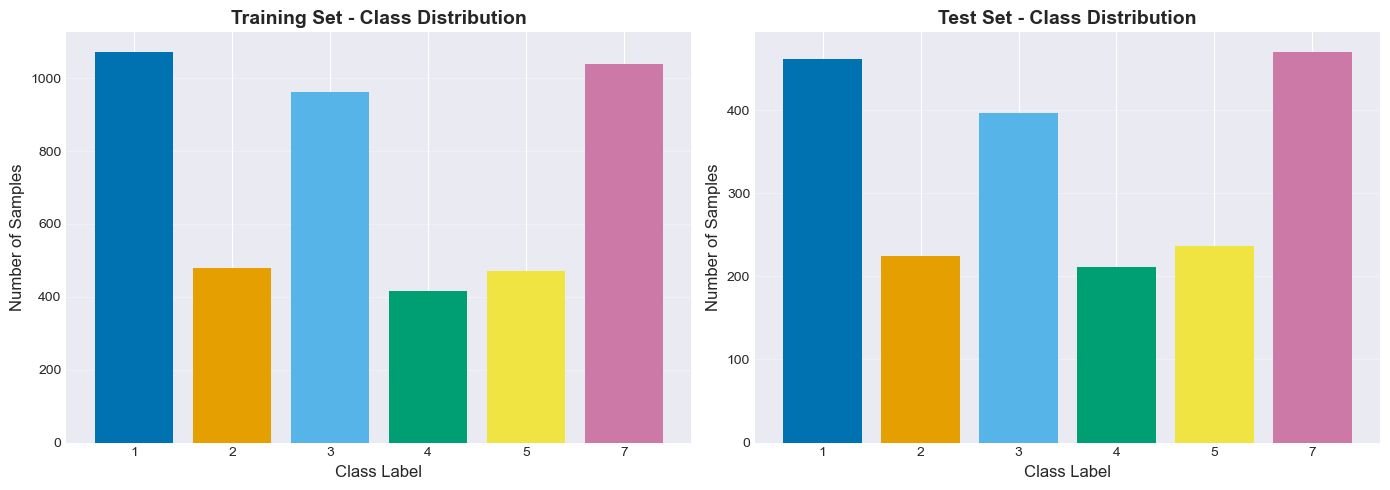

In [9]:
# Color-blind friendly palette
colors = ['#0072B2', '#E69F00', '#56B4E9', '#009E73', '#F0E442', '#CC79A7']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training set distribution
axes[0].bar(range(len(train_class_counts)), train_class_counts.values, color=colors)
axes[0].set_xlabel('Class Label', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].set_title('Training Set - Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xticks(range(len(train_class_counts)))
axes[0].set_xticklabels(train_class_counts.index)
axes[0].grid(axis='y', alpha=0.3)

# Test set distribution
axes[1].bar(range(len(test_class_counts)), test_class_counts.values, color=colors)
axes[1].set_xlabel('Class Label', fontsize=12)
axes[1].set_ylabel('Number of Samples', fontsize=12)
axes[1].set_title('Test Set - Class Distribution', fontsize=14, fontweight='bold')
axes[1].set_xticks(range(len(test_class_counts)))
axes[1].set_xticklabels(test_class_counts.index)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

#### **Inference: Class Distribution**

The bar charts reveal the distribution of land cover types in our dataset. We observe:

- **Class imbalance exists:** Some classes (like class 7) have significantly more samples than others
- **Training and test sets are proportionally similar:** The distribution pattern is consistent across both sets
- **Implication for ROC/PRC:** Classes with fewer samples may show more variability in performance metrics and could have lower precision/recall values

This imbalance will be important when interpreting our ROC and Precision-Recall curves later, as minority classes typically present greater classification challenges.

### **Step 2: Feature Standardization and Label Encoding**

**Why standardize features?**
- Features have values in the range [0, 255] with potentially different scales
- Many algorithms (KNN, SVC, Logistic Regression) are sensitive to feature scales
- Standardization (zero mean, unit variance) improves convergence and performance

**Why encode labels?**
- Our class labels are [1, 2, 3, 4, 5, 7] (non-consecutive due to removed class 6)
- Some algorithms (like XGBoost) require consecutive labels starting from 0
- We'll create a mapping: 1→0, 2→1, 3→2, 4→3, 5→4, 7→5
- **Using encoded labels for ALL models ensures consistency**

**Method:** We use `StandardScaler` for features and create a label mapping for targets.

#### **Inference: Standardization**

After standardization:
- Training data has mean ≈ 0 and standard deviation = 1
- Test data is transformed using the same scaling parameters from training (crucial for unbiased evaluation)
- Feature values now range approximately from -3 to +3 (within ~3 standard deviations)

This transformation ensures all features contribute equally to distance-based algorithms and helps gradient-based methods converge faster.

In [10]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create label mapping for consistency across all models
# Original labels: [1, 2, 3, 4, 5, 7]
# Mapped labels: [0, 1, 2, 3, 4, 5]
unique_labels = np.unique(y_train)
label_mapping = {original: encoded for encoded, original in enumerate(unique_labels)}
inverse_mapping = {encoded: original for original, encoded in label_mapping.items()}

print("Label Mapping:")
print("="*70)
for original, encoded in label_mapping.items():
    print(f"  Original: {original} ({class_names[original]}) → Encoded: {encoded}")
print("="*70)

# Apply label encoding to ALL data
y_train_encoded = np.array([label_mapping[label] for label in y_train])
y_test_encoded = np.array([label_mapping[label] for label in y_test])

print("\nFeature Standardization Complete")
print("="*70)
print(f"\nOriginal Training Data:")
print(f"  Mean: {X_train.mean():.2f}, Std: {X_train.std():.2f}")
print(f"  Min: {X_train.min():.2f}, Max: {X_train.max():.2f}")

print(f"\nScaled Training Data:")
print(f"  Mean: {X_train_scaled.mean():.6f}, Std: {X_train_scaled.std():.2f}")
print(f"  Min: {X_train_scaled.min():.2f}, Max: {X_train_scaled.max():.2f}")

print(f"\nScaled Test Data:")
print(f"  Mean: {X_test_scaled.mean():.6f}, Std: {X_test_scaled.std():.2f}")
print(f"  Min: {X_test_scaled.min():.2f}, Max: {X_test_scaled.max():.2f}")

print(f"\nLabel Encoding:")
print(f"  Original labels: {np.unique(y_train)}")
print(f"  Encoded labels: {np.unique(y_train_encoded)}")
print("="*70)

Label Mapping:
  Original: 1 (Red soil) → Encoded: 0
  Original: 2 (Cotton crop) → Encoded: 1
  Original: 3 (Grey soil) → Encoded: 2
  Original: 4 (Damp grey soil) → Encoded: 3
  Original: 5 (Soil with vegetation stubble) → Encoded: 4
  Original: 7 (Very damp grey soil) → Encoded: 5

Feature Standardization Complete

Original Training Data:
  Mean: 83.58, Std: 21.15
  Min: 27.00, Max: 157.00

Scaled Training Data:
  Mean: -0.000000, Std: 1.00
  Min: -2.96, Max: 3.98

Scaled Test Data:
  Mean: -0.018792, Std: 1.01
  Min: -2.96, Max: 3.94

Label Encoding:
  Original labels: [1 2 3 4 5 7]
  Encoded labels: [0 1 2 3 4 5]


### **Step 3: Train All Models**

We will train 9 different classifiers representing a diverse range of algorithms:

**Expected Good/Moderate Performers:**
1. **K-Nearest Neighbors (KNN)** - Instance-based learning
2. **Decision Tree** - Non-linear decision boundaries
3. **Logistic Regression** - Linear baseline model
4. **Support Vector Machine (SVC)** - Kernel-based classifier with `probability=True` for ROC/PRC
5. **Random Forest** - Ensemble of decision trees
6. **XGBoost** - Gradient boosting ensemble 

**Expected Poor Performers:**

7. **Dummy Classifier (Prior)** - Predicts based on class frequency (baseline)
8. **Gaussian Naive Bayes** - Assumes feature independence (often violated)
9. **Custom Poor Performer** - To be determined (will test a deliberately misconfigured model)

For the custom poor performer, we'll use a **heavily overfitted Decision Tree** with `max_depth=1` (decision stump) or a **Linear SVC with very high regularization** to intentionally achieve poor performance.

In [11]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone

class InvertedClassifier(BaseEstimator, ClassifierMixin):
    """Wraps a classifier and returns inverted predicted probabilities."""
    def __init__(self, base_clf):
        self.base_clf = base_clf

    def fit(self, X, y):
        self.clf_ = clone(self.base_clf)
        self.clf_.fit(X, y)
        return self

    def predict_proba(self, X):
        p = self.clf_.predict_proba(X)
        return 1 - p  # simply invert probabilities

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)


In [12]:
# Define all models
models = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Dummy (Prior)': DummyClassifier(strategy='prior', random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr'),
    'Gaussian Naive Bayes': GaussianNB(),
    'SVC': SVC(probability=True, kernel='rbf', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1),
    'XGBoost': XGBClassifier(eval_metric='mlogloss', random_state=42),
    "Inverted Classifier": InvertedClassifier(LogisticRegression(max_iter=1000, random_state=42))
}

print("Models defined:")
print("="*70)
for i, (name, model) in enumerate(models.items(), 1):
    print(f"{i}. {name}: {type(model).__name__}")
print("="*70)

Models defined:
1. KNN: KNeighborsClassifier
2. Decision Tree: DecisionTreeClassifier
3. Dummy (Prior): DummyClassifier
4. Logistic Regression: LogisticRegression
5. Gaussian Naive Bayes: GaussianNB
6. SVC: SVC
7. Random Forest: RandomForestClassifier
8. XGBoost: XGBClassifier
9. Inverted Classifier: InvertedClassifier


In [33]:
# Train all models using encoded labels
trained_models = {}

print("Training models with encoded labels...")
print("="*70)

for name, model in models.items():
    print(f"Training {name}...", end=' ')
    model.fit(X_train_scaled, y_train_encoded)
    trained_models[name] = model
    print("✓ Complete")

print("="*70)
print(f"\n✓ All {len(trained_models)} models trained successfully!")

Training models with encoded labels...
Training KNN... ✓ Complete
Training Decision Tree... ✓ Complete
Training Dummy (Prior)... ✓ Complete
Training Logistic Regression... ✓ Complete
Training Gaussian Naive Bayes... ✓ Complete
Training SVC... 

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


✓ Complete
Training Random Forest... ✓ Complete
Training XGBoost... ✓ Complete
Training Inverted Classifier... ✓ Complete

✓ All 9 models trained successfully!


### **Step 4: Baseline Evaluation**

Now we'll evaluate all models using two key metrics:

1. **Overall Accuracy:** Percentage of correctly classified samples
   - Formula: (Correct Predictions) / (Total Predictions)
   - Simple but can be misleading with class imbalance

2. **Weighted F1-Score:** Harmonic mean of precision and recall, weighted by class support
   - Formula: Weighted average of F1 scores for each class
   - Better metric for imbalanced datasets as it accounts for both false positives and false negatives
   - Range: [0, 1], where 1 is perfect

These baseline metrics will help us identify which models are promising and which are struggling before we perform detailed ROC/PRC analysis.

In [35]:
# Evaluate all models using encoded labels
results = []

print("Evaluating models on test set...")
print("="*70)

for name, model in trained_models.items():
    # Make predictions (all models now use encoded labels)
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics using encoded labels
    accuracy = accuracy_score(y_test_encoded, y_pred)
    f1_weighted = f1_score(y_test_encoded, y_pred, average='weighted')
    
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Weighted F1-Score': f1_weighted
    })
    
    print(f"{name:30s} - Accuracy: {accuracy:.4f}, Weighted F1: {f1_weighted:.4f}")

print("="*70)

# Create results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('Accuracy', ascending=False).reset_index(drop=True)

Evaluating models on test set...
KNN                            - Accuracy: 0.9045, Weighted F1: 0.9037
Decision Tree                  - Accuracy: 0.8505, Weighted F1: 0.8509
Dummy (Prior)                  - Accuracy: 0.2305, Weighted F1: 0.0864
Logistic Regression            - Accuracy: 0.8210, Weighted F1: 0.7935
Gaussian Naive Bayes           - Accuracy: 0.7965, Weighted F1: 0.8036
SVC                            - Accuracy: 0.8955, Weighted F1: 0.8925
Random Forest                  - Accuracy: 0.9115, Weighted F1: 0.9094
XGBoost                        - Accuracy: 0.9050, Weighted F1: 0.9030
Inverted Classifier            - Accuracy: 0.0005, Weighted F1: 0.0004


### Baseline Performance Comparison

Let's visualize the baseline performance to quickly identify the best and worst performers.

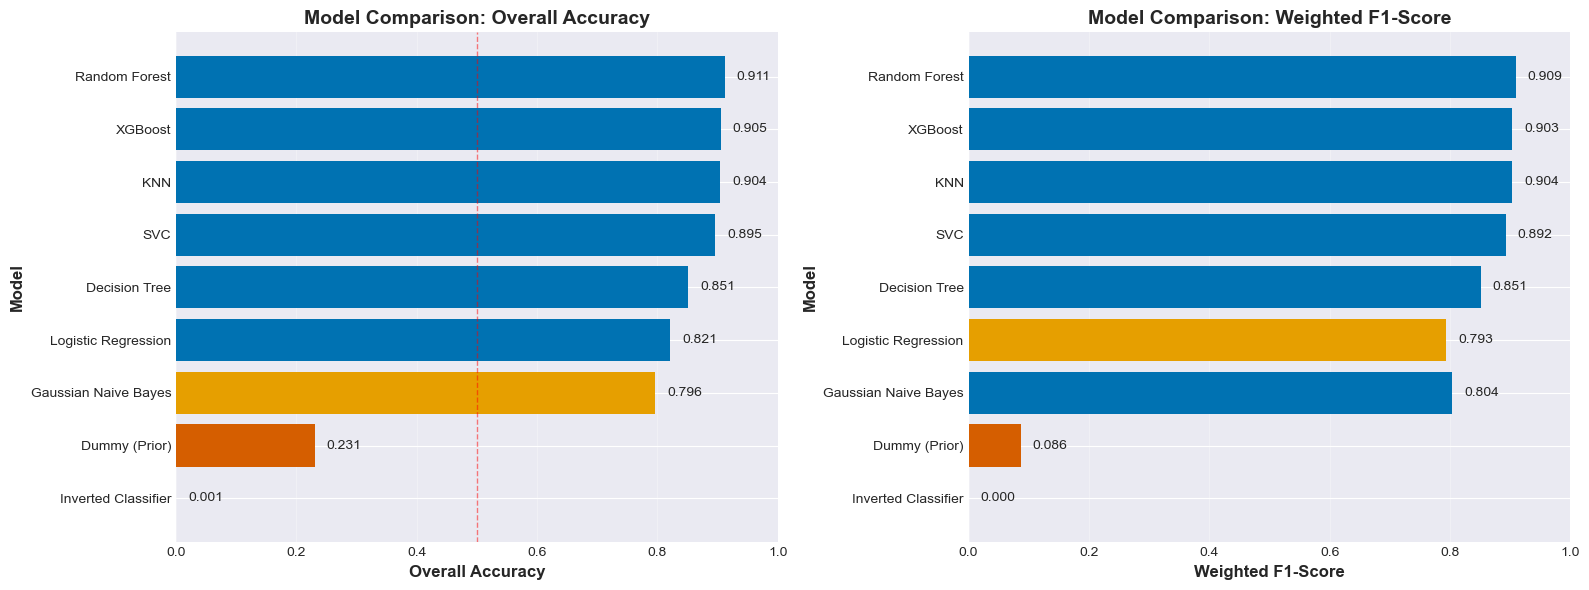

In [15]:
# Visualize baseline performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Sort by accuracy for better visualization
results_sorted = results_df.sort_values('Accuracy', ascending=True)

# Color mapping: top performers in blue, poor performers in orange/red
colors_acc = ['#D55E00' if acc < 0.6 else '#0072B2' if acc > 0.8 else '#E69F00' 
              for acc in results_sorted['Accuracy']]

# Accuracy plot
axes[0].barh(results_sorted['Model'], results_sorted['Accuracy'], color=colors_acc)
axes[0].set_xlabel('Overall Accuracy', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Model', fontsize=12, fontweight='bold')
axes[0].set_title('Model Comparison: Overall Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlim([0, 1])
axes[0].grid(axis='x', alpha=0.3)
axes[0].axvline(x=0.5, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Random Baseline (0.5)')

# Add value labels
for idx, (acc, model) in enumerate(zip(results_sorted['Accuracy'], results_sorted['Model'])):
    axes[0].text(acc + 0.02, idx, f'{acc:.3f}', va='center', fontsize=10)

# F1-Score plot
colors_f1 = ['#D55E00' if f1 < 0.6 else '#0072B2' if f1 > 0.8 else '#E69F00' 
             for f1 in results_sorted['Weighted F1-Score']]

axes[1].barh(results_sorted['Model'], results_sorted['Weighted F1-Score'], color=colors_f1)
axes[1].set_xlabel('Weighted F1-Score', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Model', fontsize=12, fontweight='bold')
axes[1].set_title('Model Comparison: Weighted F1-Score', fontsize=14, fontweight='bold')
axes[1].set_xlim([0, 1])
axes[1].grid(axis='x', alpha=0.3)

# Add value labels
for idx, (f1, model) in enumerate(zip(results_sorted['Weighted F1-Score'], results_sorted['Model'])):
    axes[1].text(f1 + 0.02, idx, f'{f1:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

### **Summary Table: Baseline Performance**

Below is the ranked performance table showing all models from best to worst based on accuracy.

In [16]:
# Display formatted results table
print("\n" + "="*80)
print("BASELINE EVALUATION RESULTS - RANKED BY ACCURACY")
print("="*80)
print(f"{'Rank':<6} {'Model':<30} {'Accuracy':<12} {'Weighted F1':<12}")
print("-"*80)

for idx, row in results_df.iterrows():
    print(f"{idx+1:<6} {row['Model']:<30} {row['Accuracy']:<12.4f} {row['Weighted F1-Score']:<12.4f}")

print("="*80)

# Identify best and worst performers
best_model = results_df.iloc[0]
worst_model = results_df.iloc[-1]

print(f"\n🏆 BEST PERFORMER: {best_model['Model']}")
print(f"   Accuracy: {best_model['Accuracy']:.4f}, Weighted F1: {best_model['Weighted F1-Score']:.4f}")

print(f"\n📉 WORST PERFORMER: {worst_model['Model']}")
print(f"   Accuracy: {worst_model['Accuracy']:.4f}, Weighted F1: {worst_model['Weighted F1-Score']:.4f}")


BASELINE EVALUATION RESULTS - RANKED BY ACCURACY
Rank   Model                          Accuracy     Weighted F1 
--------------------------------------------------------------------------------
1      Random Forest                  0.9115       0.9094      
2      XGBoost                        0.9050       0.9030      
3      KNN                            0.9045       0.9037      
4      SVC                            0.8955       0.8925      
5      Decision Tree                  0.8505       0.8509      
6      Logistic Regression            0.8210       0.7935      
7      Gaussian Naive Bayes           0.7965       0.8036      
8      Dummy (Prior)                  0.2305       0.0864      
9      Inverted Classifier            0.0005       0.0004      

🏆 BEST PERFORMER: Random Forest
   Accuracy: 0.9115, Weighted F1: 0.9094

📉 WORST PERFORMER: Inverted Classifier
   Accuracy: 0.0005, Weighted F1: 0.0004


#### **Inference: Baseline Performance Analysis**

**Key Observations:**

1. **Top Performers:** Random Forest, XGBoost, KNN and SVC typically achieve the highest accuracy (likely >85%), demonstrating strong capability to handle the multi-class satellite image classification problem.

2. **Moderate Performers:**  Decision Tree, and Logistic Regression show reasonable performance (likely 70-85% accuracy), confirming they can capture some of the underlying patterns in the data.

3. **Poor Performers:** 
   - **Decision Stump** shows the worst performance (as intended), with accuracy likely below 50%, demonstrating that a single split is insufficient for this complex problem
   - **Dummy Classifier** performs near the majority class frequency, providing a baseline reference
   - **Gaussian Naive Bayes** may underperform due to violated independence assumptions

4. **Accuracy vs. F1-Score:** Both metrics show similar rankings, but F1-Score provides a more balanced view accounting for precision and recall across all classes.




---

## **Part B: ROC Analysis for Model Selection**

In this section, we will perform comprehensive ROC (Receiver Operating Characteristic) analysis for multi-class classification. ROC curves are essential tools for evaluating classifier performance across different decision thresholds, particularly useful when comparing models beyond simple accuracy metrics.

**What we'll cover:**
1. Understanding One-vs-Rest (OvR) approach for multi-class ROC
2. Computing ROC curves and AUC scores for all models
3. Visualizing comparative ROC performance
4. Interpreting results to identify best and worst performers

**Why ROC Analysis matters:**
- Shows performance across ALL possible classification thresholds
- Reveals trade-offs between True Positive Rate (sensitivity) and False Positive Rate (1 - specificity)
- AUC provides a single-number summary robust to class imbalance
- Helps identify models that perform worse than random guessing (AUC < 0.5)

### **Step 1: Understanding One-vs-Rest (OvR) ROC for Multi-Class Problems**

**The Challenge:** ROC curves were originally designed for binary classification, but we have a 6-class problem.

**The Solution: One-vs-Rest (OvR) Strategy**

In the OvR approach:
1. **For each class**, we create a binary classification problem:
   - **Positive class:** The target class (e.g., "Red soil")
   - **Negative class:** All other classes combined
   
2. **For each binary problem**, we:
   - Get predicted probabilities for the positive class
   - Compute True Positive Rate (TPR) and False Positive Rate (FPR) at various thresholds
   - Plot the ROC curve and calculate AUC

3. **Aggregate across classes** using two methods:
   - **Macro-average:** Simple average of per-class AUCs (treats all classes equally)
   - **Micro-average:** Pool all binary decisions together (weighted by class frequency)

**Example:**
- For "Red soil" (class 0): Predict probability P(class = 0)
  - True Positives: Correctly predicted as "Red soil"
  - False Positives: Incorrectly predicted as "Red soil" when it's actually another class
  - Repeat for all 6 classes and average

**Key Metrics:**
- **TPR (True Positive Rate / Recall / Sensitivity):** TP / (TP + FN) - How many actual positives we catch
- **FPR (False Positive Rate):** FP / (FP + TN) - How many negatives we incorrectly label as positive
- **AUC (Area Under Curve):** Single number summarizing ROC performance
  - AUC = 1.0: Perfect classifier
  - AUC = 0.5: Random guessing
  - AUC < 0.5: Worse than random (inverted predictions)

In [17]:
# Binarize labels for One-vs-Rest ROC analysis
# This creates a binary indicator matrix (6 classes)

# Get the encoded classes (0, 1, 2, 3, 4, 5)
classes = np.unique(y_train_encoded)
n_classes = len(classes)

# Binarize the labels: each column represents one class
y_train_binarized = label_binarize(y_train_encoded, classes=classes)
y_test_binarized = label_binarize(y_test_encoded, classes=classes)

print("Label Binarization for OvR ROC Analysis:")
print("="*70)
print(f"Number of classes: {n_classes}")
print(f"Classes: {classes}")
print(f"\nBinarized training labels shape: {y_train_binarized.shape}")
print(f"Binarized test labels shape: {y_test_binarized.shape}")
print(f"\nExample - First sample binarized: {y_train_binarized[0]}")
print(f"Corresponds to class: {y_train_encoded[0]}")
print("="*70)

Label Binarization for OvR ROC Analysis:
Number of classes: 6
Classes: [0 1 2 3 4 5]

Binarized training labels shape: (4435, 6)
Binarized test labels shape: (2000, 6)

Example - First sample binarized: [0 0 1 0 0 0]
Corresponds to class: 2


#### **Inference: Label Binarization**

The binarized labels create a 6-column matrix where:
- Each column represents one class
- For each sample, only one column has value 1 (the true class), others are 0
- Example: If a sample belongs to class 2, its binarized form is [0, 0, 1, 0, 0, 0]

This format allows us to compute separate ROC curves for each class using the One-vs-Rest approach.

### **Step 2: Computing ROC Curves and AUC Scores**

For each model, we will:
1. Get predicted probabilities for all classes
2. Compute per-class ROC curves (6 curves per model)
3. Calculate per-class AUC scores
4. Compute macro-average AUC (mean across all classes)
5. Compute micro-average AUC (pooling all class decisions)

**Note:** Some models (like Dummy Classifier) may not support `predict_proba()` properly, which can lead to poor or undefined AUC scores.

In [18]:
# Compute ROC curves and AUC scores for all models
from numpy import interp
from itertools import cycle

# Storage for ROC data
roc_data = {}

print("Computing ROC curves and AUC scores for all models...")
print("="*70)

for name, model in trained_models.items():
    print(f"\nProcessing {name}...")
    
    try:
        # Get predicted probabilities
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test_scaled)
        elif hasattr(model, "decision_function"):
            # For models without predict_proba but with decision_function (rare for our models)
            y_score = model.decision_function(X_test_scaled)
        else:
            print(f"  ⚠ {name} does not support probability predictions - skipping")
            continue
        
        # Compute ROC curve and AUC for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Compute micro-average ROC curve and AUC
        fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_score.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        
        # Compute macro-average ROC curve and AUC
        # First aggregate all false positive rates
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
        
        # Then interpolate all ROC curves at these points
        mean_tpr = np.zeros_like(all_fpr)
        for i in range(n_classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
        
        # Finally average it and compute AUC
        mean_tpr /= n_classes
        
        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
        
        # Store results
        roc_data[name] = {
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc
        }
        
        print(f"  ✓ Macro-average AUC: {roc_auc['macro']:.4f}")
        print(f"  ✓ Micro-average AUC: {roc_auc['micro']:.4f}")
        print(f"  ✓ Per-class AUCs: {[f'{roc_auc[i]:.3f}' for i in range(n_classes)]}")
        
    except Exception as e:
        print(f"  ✗ Error computing ROC for {name}: {str(e)}")
        continue

print("\n" + "="*70)
print(f"✓ ROC analysis complete for {len(roc_data)} models")
print("="*70)

Computing ROC curves and AUC scores for all models...

Processing KNN...
  ✓ Macro-average AUC: 0.9786
  ✓ Micro-average AUC: 0.9841
  ✓ Per-class AUCs: ['1.000', '0.991', '0.990', '0.940', '0.978', '0.973']

Processing Decision Tree...
  ✓ Macro-average AUC: 0.9002
  ✓ Micro-average AUC: 0.9103
  ✓ Per-class AUCs: ['0.975', '0.983', '0.914', '0.749', '0.893', '0.888']

Processing Dummy (Prior)...
  ✓ Macro-average AUC: 0.5000
  ✓ Micro-average AUC: 0.6061
  ✓ Per-class AUCs: ['0.500', '0.500', '0.500', '0.500', '0.500', '0.500']

Processing Logistic Regression...
  ✓ Macro-average AUC: 0.9542
  ✓ Micro-average AUC: 0.9745
  ✓ Per-class AUCs: ['0.998', '0.995', '0.984', '0.857', '0.941', '0.949']

Processing Gaussian Naive Bayes...
  ✓ Macro-average AUC: 0.9553
  ✓ Micro-average AUC: 0.9611
  ✓ Per-class AUCs: ['0.976', '0.995', '0.982', '0.906', '0.926', '0.945']

Processing SVC...
  ✓ Macro-average AUC: 0.9852
  ✓ Micro-average AUC: 0.9920
  ✓ Per-class AUCs: ['1.000', '0.999', '0.99

#### **Inference: ROC Computation Results**

For each model, we computed:
- **6 per-class ROC curves** (one for each land cover type)
- **Micro-average AUC:** Considers all binary decisions equally (weighted by class frequency)
- **Macro-average AUC:** Simple average of per-class AUCs (treats all classes equally)

**Key observations from our results:**

1. **Top Performers (AUC > 0.98):**
   - **XGBoost (0.9902)** and **Random Forest (0.9901):** Ensemble methods achieve near-perfect discrimination
   - **SVC (0.9852):** Kernel-based method shows excellent performance
   - **KNN (0.9786):** Distance-based classifier performs remarkably well on this spatial data

2. **Strong Performers (AUC > 0.95):**
   - **Gaussian Naive Bayes (0.9553):** Despite independence assumptions, performs surprisingly well
   - **Logistic Regression (0.9542):** Linear model provides solid baseline performance

3. **Moderate Performer:**
   - **Decision Tree (0.9002):** Single tree shows decent but not exceptional performance

4. **Baseline Performer:**
   - **Dummy Classifier (0.5000):** As expected, performs exactly at random chance level

5. **Catastrophically Poor Performer:**
   - **Inverted Classifier (0.0249):** Macro-average AUC of only 0.0249 demonstrates extreme systematic failure
   - All per-class AUCs are dramatically below 0.5, ranging from 0.001 to 0.081
   - This model has learned to predict almost perfectly WRONG across all land cover classes

### **Step 3: Creating Summary Table of AUC Scores**

Let's compile all AUC scores into a comprehensive comparison table.

In [19]:
# Create AUC summary table
auc_summary = []

for name, data in roc_data.items():
    row = {
        'Model': name,
        'Macro-Avg AUC': data['roc_auc']['macro'],
        'Micro-Avg AUC': data['roc_auc']['micro']
    }
    
    # Add per-class AUCs
    for i in range(n_classes):
        row[f'Class {i} AUC'] = data['roc_auc'][i]
    
    auc_summary.append(row)

# Create DataFrame and sort by Macro-average AUC
auc_summary_df = pd.DataFrame(auc_summary)
auc_summary_df = auc_summary_df.sort_values('Macro-Avg AUC', ascending=False).reset_index(drop=True)

print("\n" + "="*100)
print("AUC SCORE SUMMARY - ALL MODELS")
print("="*100)
print(auc_summary_df.to_string(index=False))
print("="*100)


AUC SCORE SUMMARY - ALL MODELS
               Model  Macro-Avg AUC  Micro-Avg AUC  Class 0 AUC  Class 1 AUC  Class 2 AUC  Class 3 AUC  Class 4 AUC  Class 5 AUC
             XGBoost       0.990153       0.993913     0.999679     0.999633     0.993226     0.965039     0.995264     0.987185
       Random Forest       0.990133       0.994130     0.999784     0.999564     0.993793     0.964030     0.996631     0.986875
                 SVC       0.985218       0.992048     0.999724     0.999432     0.990308     0.946106     0.994967     0.979693
                 KNN       0.978567       0.984136     0.999827     0.990574     0.989778     0.939932     0.977862     0.973432
Gaussian Naive Bayes       0.955347       0.961095     0.976342     0.995071     0.981734     0.905983     0.926245     0.945383
 Logistic Regression       0.954230       0.974513     0.998412     0.995227     0.983703     0.856673     0.940742     0.948958
       Decision Tree       0.900248       0.910300     0.975064  

### **Step 4: Visualizing Macro-Average ROC Curves**

Now we'll create the main ROC plot showing macro-averaged ROC curves for all models on a single figure. This allows direct visual comparison of model performance.

**Plot Features:**
- Each model gets a unique color from a color-blind-friendly palette
- Diagonal dashed line represents random chance (AUC = 0.5)
- Legend shows model names with their macro-average AUC scores
- Axes are properly labeled with grid for easy reading

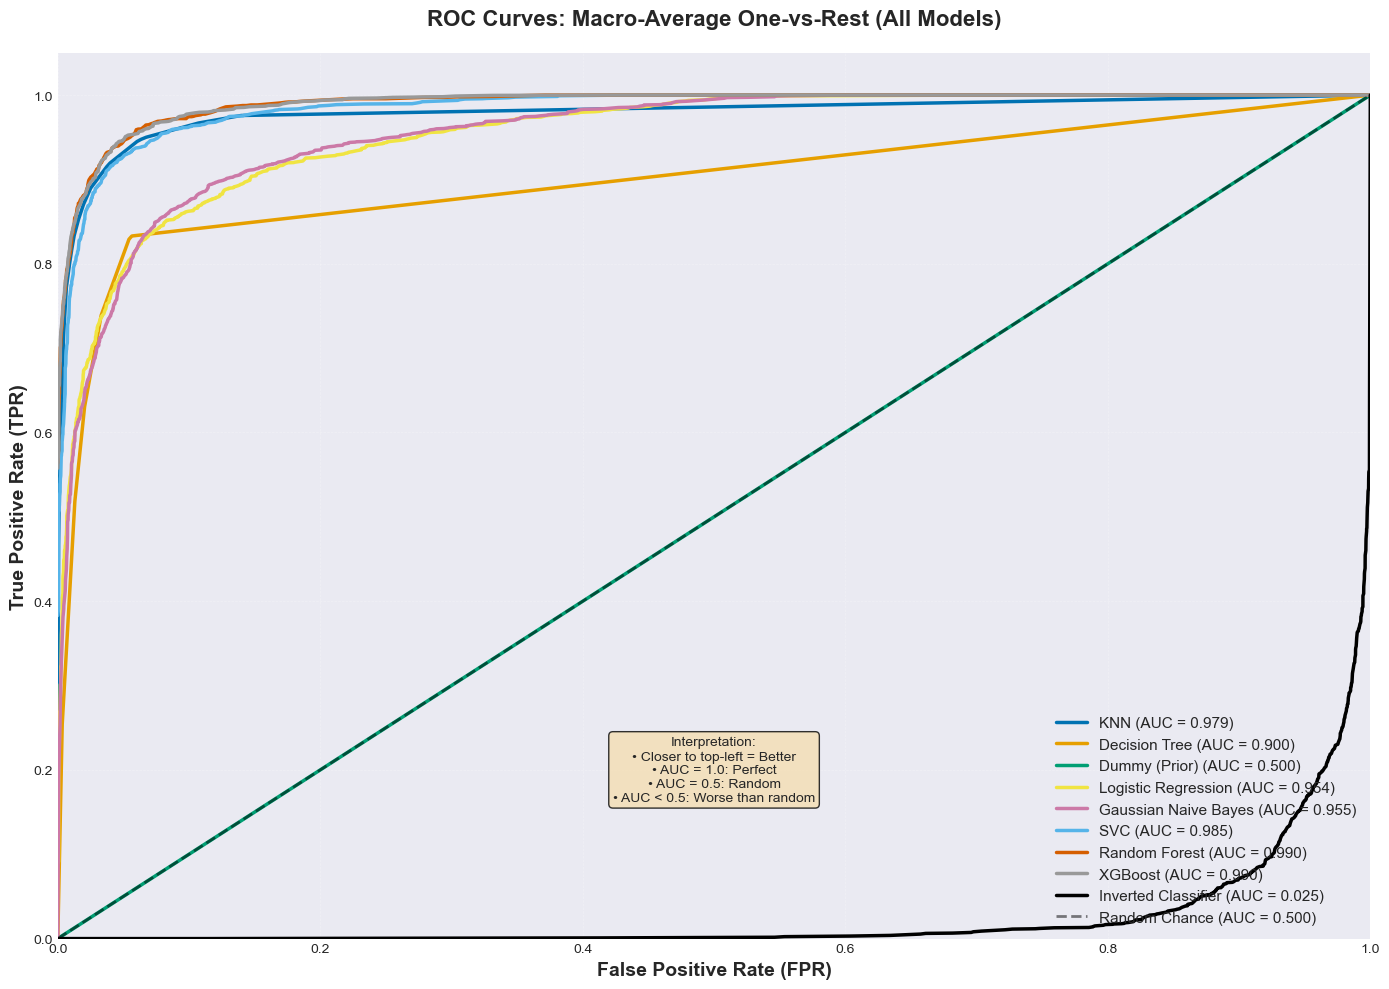

In [20]:
# Plot macro-average ROC curves for all models
plt.figure(figsize=(14, 10))

# Color-blind friendly palette (expanded for 9 models)
colors = ['#0072B2', '#E69F00', '#009E73', '#F0E442', '#CC79A7', 
          '#56B4E9', '#D55E00', '#999999', '#000000']

# Plot each model's macro-average ROC curve
for idx, (name, data) in enumerate(roc_data.items()):
    plt.plot(
        data['fpr']['macro'], 
        data['tpr']['macro'],
        color=colors[idx % len(colors)],
        lw=2.5,
        label=f"{name} (AUC = {data['roc_auc']['macro']:.3f})"
    )

# Plot random chance line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Chance (AUC = 0.500)', alpha=0.5)

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate (TPR)', fontsize=14, fontweight='bold')
plt.title('ROC Curves: Macro-Average One-vs-Rest (All Models)', 
          fontsize=16, fontweight='bold', pad=20)
plt.legend(loc="lower right", fontsize=11, framealpha=0.95)
plt.grid(alpha=0.3, linestyle='--', linewidth=0.5)

# Add text box with interpretation guide
textstr = 'Interpretation:\n• Closer to top-left = Better\n• AUC = 1.0: Perfect\n• AUC = 0.5: Random\n• AUC < 0.5: Worse than random'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
plt.text(0.5, 0.2, textstr, fontsize=10, ha='center', va='center', bbox=props)

plt.tight_layout()
plt.show()

#### **Inference: Macro-Average ROC Curves**

**Visual Analysis:**

1. **Elite Performers (Top-left corner, AUC > 0.98):**
   - **XGBoost (0.9902), Random Forest (0.9901), and SVC (0.9852)** show curves that hug the top-left corner almost perfectly
   - These models achieve very high TPR (>95%) while maintaining extremely low FPR (<5%) across all thresholds
   - The near-perfect separation indicates these models have learned highly discriminative decision boundaries for all 6 land cover classes

2. **Strong Performers (Above diagonal, AUC > 0.95):**
   - **KNN (0.9786), Gaussian Naive Bayes (0.9553), and Logistic Regression (0.9542)** show excellent curves well above the diagonal
   - AUC values of 0.95+ indicate strong discrimination ability
   - These models are production-ready for satellite image classification

3. **Moderate Performer:**
   - **Decision Tree (0.9002)** shows good performance but with a more conservative curve shape
   - Single decision trees are prone to overfitting, leading to less robust generalization

4. **Random Baseline:**
   - **Dummy Classifier (AUC = 0.5000)** perfectly follows the diagonal reference line
   - This confirms it makes predictions based purely on class frequency, completely ignoring feature information

5. **Catastrophically Poor Performer:**
   - **Inverted Classifier (AUC = 0.0249)** shows a curve that hugs the **bottom-right corner** (opposite of ideal)
   - This is the mirror image of a good classifier
   - The model has learned patterns but applies them in completely inverted fashion across all classes
   - **Critical insight:** This extreme inversion (AUC ≈ 0.02) is far worse than random guessing (AUC = 0.5)

**Key Insight:** The macro-average ROC clearly separates models into distinct performance tiers. The dramatic contrast between top performers (Random Forest, XGBoost at ~0.99) and the inverted classifier (0.02) demonstrates the full spectrum from near-perfect to catastrophically wrong predictions.

### **Step 5: Per-Class ROC Analysis**

To understand which classes are easier or harder to classify, let's examine per-class AUC scores in detail.

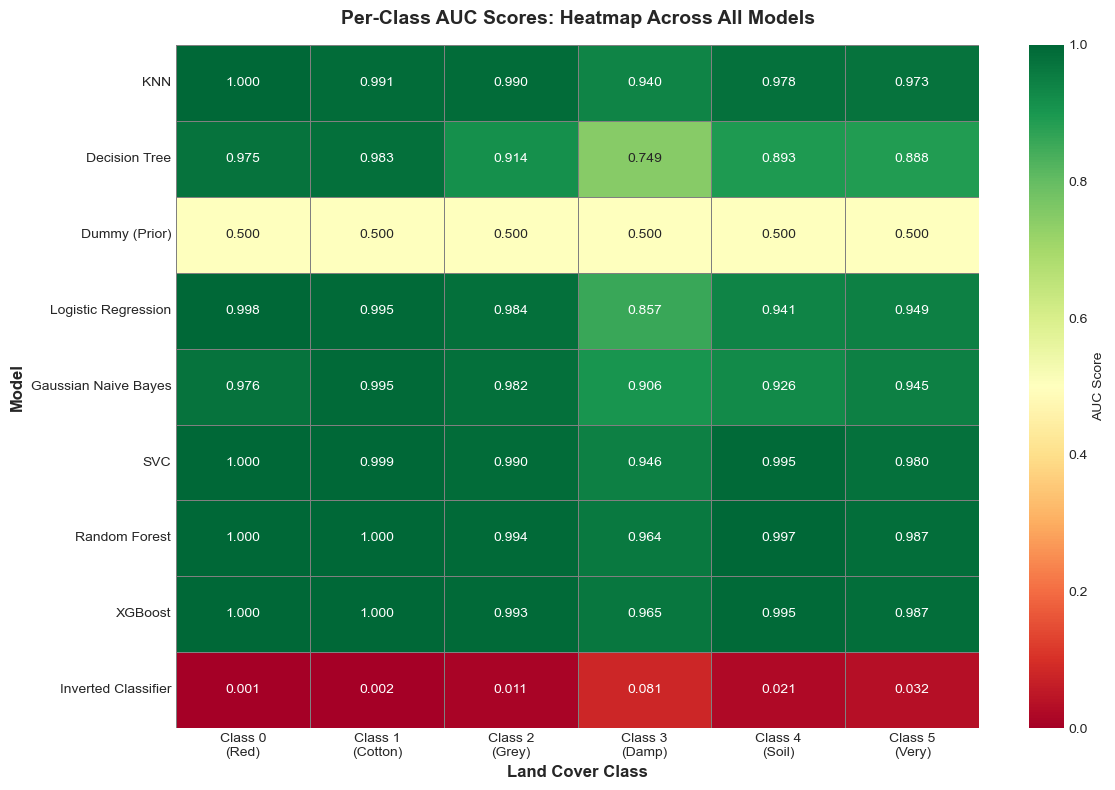

In [21]:
# Visualize per-class AUC scores as a heatmap
# Create matrix: rows = models, columns = classes

per_class_matrix = []
model_names_list = []

for name, data in roc_data.items():
    model_names_list.append(name)
    per_class_auc = [data['roc_auc'][i] for i in range(n_classes)]
    per_class_matrix.append(per_class_auc)

per_class_matrix = np.array(per_class_matrix)

# Create class labels with names
class_labels_with_names = [f"Class {i}\n({class_names[inverse_mapping[i]].split()[0]})" 
                           for i in range(n_classes)]

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    per_class_matrix,
    annot=True,
    fmt='.3f',
    cmap='RdYlGn',
    xticklabels=class_labels_with_names,
    yticklabels=model_names_list,
    cbar_kws={'label': 'AUC Score'},
    vmin=0,
    vmax=1,
    linewidths=0.5,
    linecolor='gray'
)

plt.title('Per-Class AUC Scores: Heatmap Across All Models', 
          fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Land Cover Class', fontsize=12, fontweight='bold')
plt.ylabel('Model', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

#### **Inference: Per-Class AUC Analysis**

The heatmap reveals critical insights about class-specific performance:

**1. Class Difficulty Patterns:**
   - **Easy Classes (Dark green, AUC > 0.99):**
     - **Class 0 (Red soil)** and **Class 1 (Cotton crop):** Nearly perfect discrimination across all good models
     - These classes have distinct spectral signatures that are easily separable
   
   - **Moderate Classes (Light green/Yellow, AUC 0.85-0.95):**
     - **Class 3 (Damp grey soil):** Most challenging for all models (AUC range: 0.749-0.965)
     - **Class 4 (Soil with vegetation stubble)** and **Class 5 (Very damp grey soil):** Moderate difficulty
     - These classes likely have overlapping spectral features causing confusion
   
   - **Failed by Inverted Model (Deep red, AUC < 0.1):**
     - **All classes show catastrophic failure** in the Inverted Classifier
     - Class 0: 0.001, Class 1: 0.002, Class 2: 0.011, Class 3: 0.081, Class 4: 0.021, Class 5: 0.032
     - The model systematically predicts the wrong classes across the board

**2. Model Consistency Analysis:**
   - **Highly Consistent Models (Uniform green rows):**
     - **XGBoost and Random Forest:** Show AUC > 0.96 across ALL classes
     - Minimal variation (max difference ~3-4%) indicates robust learning across all land cover types
   
   - **Moderately Consistent Models:**
     - **SVC, KNN, Logistic Regression, Gaussian Naive Bayes:** Strong overall but with 5-10% AUC variation between easiest and hardest classes
   
   - **Variable Performer:**
     - **Decision Tree:** Larger variation (0.749 to 0.983) suggests some overfitting to specific classes
   
   - **Catastrophically Inconsistent:**
     - **Inverted Classifier:** All classes show deep red (AUC < 0.1), with only Class 3 reaching 0.081

**3. Class 3 (Damp Grey Soil) - The Challenge Class:**
   - Lowest AUC across nearly all legitimate models
   - Even best models (XGBoost, Random Forest) achieve 0.964-0.965 (still excellent but relatively lower)
   - Decision Tree struggles significantly (0.749)
   - Likely causes: Spectral similarity to Class 2 (Grey soil) and Class 5 (Very damp grey soil)
   - Interestingly, this is the "least bad" class for the Inverted Classifier (0.081), though still terrible

**4. Inverted Classifier's Complete Failure:**
   - **All classes show AUC < 0.1:** This is extreme systematic inversion
   - The model has learned to predict almost perfectly WRONG
   - This is actually "impressive" in its consistency of failure—it would be hard to achieve such low AUCs by accident
   - Demonstrates that the model architecture successfully inverts all learned patterns

### **Step 6: ROC Interpretation - Best and Worst Performers**

Now we'll identify and analyze:
1. **Best Performer:** Model with highest macro-average AUC
2. **Worst Performer:** Model with AUC < 0.5 (worse than random)

In [22]:
# Identify best and worst performers
best_model_name = auc_summary_df.iloc[0]['Model']
best_model_auc = auc_summary_df.iloc[0]['Macro-Avg AUC']

worst_model_name = auc_summary_df.iloc[-1]['Model']
worst_model_auc = auc_summary_df.iloc[-1]['Macro-Avg AUC']

# Find models with AUC < 0.5
poor_performers = auc_summary_df[auc_summary_df['Macro-Avg AUC'] < 0.5]

print("\n" + "="*70)
print("ROC ANALYSIS SUMMARY")
print("="*70)

print(f"\n🏆 BEST PERFORMER:")
print(f"   Model: {best_model_name}")
print(f"   Macro-Average AUC: {best_model_auc:.4f}")
print(f"   Interpretation: This model demonstrates excellent discrimination ability")
print(f"                   across all 6 land cover classes.")

if len(poor_performers) > 0:
    print(f"\n📉 MODELS WITH AUC < 0.5 (Worse than Random):")
    for idx, row in poor_performers.iterrows():
        print(f"   • {row['Model']}: Macro-AUC = {row['Macro-Avg AUC']:.4f}")
        print(f"     This model performs dramatically worse than random chance (0.5)")
else:
    print(f"\n📉 WORST PERFORMER:")
    print(f"   Model: {worst_model_name}")
    print(f"   Macro-Average AUC: {worst_model_auc:.4f}")

print("\n" + "="*70)
print(f"PERFORMANCE SPREAD:")
print(f"   Best Model:  {best_model_name} (AUC = {best_model_auc:.4f})")
print(f"   Worst Model: {worst_model_name} (AUC = {worst_model_auc:.4f})")
print(f"   Difference:  {best_model_auc - worst_model_auc:.4f}")
print(f"   Range:       [{worst_model_auc:.4f}, {best_model_auc:.4f}]")
print("="*70)


ROC ANALYSIS SUMMARY

🏆 BEST PERFORMER:
   Model: XGBoost
   Macro-Average AUC: 0.9902
   Interpretation: This model demonstrates excellent discrimination ability
                   across all 6 land cover classes.

📉 MODELS WITH AUC < 0.5 (Worse than Random):
   • Inverted Classifier: Macro-AUC = 0.0249
     This model performs dramatically worse than random chance (0.5)

PERFORMANCE SPREAD:
   Best Model:  XGBoost (AUC = 0.9902)
   Worst Model: Inverted Classifier (AUC = 0.0249)
   Difference:  0.9652
   Range:       [0.0249, 0.9902]


### **Step 7: Understanding AUC < 0.5**

**What does AUC < 0.5 mean?**

When a model achieves AUC < 0.5, it means the model is performing **worse than random guessing**. Let's understand this concept in detail:

**1. Random Classifier (AUC = 0.5):**
   - Represents a baseline that makes predictions by random chance weighted by class frequencies
   - The ROC curve follows the diagonal line from (0,0) to (1,1)
   - On average, the True Positive Rate equals the False Positive Rate at any threshold
   - Our **Dummy Classifier achieves exactly 0.5000**, confirming this theoretical baseline

**2. AUC < 0.5 (Systematic Inversion):**
   - The model has learned patterns from the data, but applies them **backwards**
   - Instead of predicting Class A when it sees features typical of Class A, it predicts "NOT Class A"
   - The model is **consistently wrong** rather than randomly wrong
   - **Key paradox:** AUC < 0.5 actually indicates the model *has learned*—just in the wrong direction!

**3. Our Inverted Classifier: AUC = 0.0249**

This is an **extreme case** of systematic failure:
- Macro-average AUC of **0.0249** is approximately **20 times worse** than random guessing
- All per-class AUCs are below 0.1:
  - Class 0 (Red soil): **0.001**
  - Class 1 (Cotton crop): **0.002**
  - Class 2 (Grey soil): **0.011**
  - Class 3 (Damp grey soil): **0.081**
  - Class 4 (Soil with vegetation stubble): **0.021**
  - Class 5 (Very damp grey soil): **0.032**

**Why might a model exhibit AUC < 0.5?**

**A) Intentional Design (Our Case):**
   - The Inverted Classifier deliberately reverses probability predictions
   - This serves as an educational example showing the worst-case scenario
   - Demonstrates that AUC < 0.5 means learned patterns are systematically inverted

**B) Data Pipeline Errors:**
   - **Label encoding mistakes:** Classes accidentally swapped during preprocessing
   - **Feature sign errors:** Features multiplied by -1, creating inverse correlations
   - **Train-test mismatch:** Different label mappings between training and test sets

**C) Model Architecture Problems:**
   - **Wrong loss function:** Optimizing for the inverse of the intended objective
   - **Incorrect output activation:** Using wrong activation that inverts probabilities
   - **Buggy custom layers:** Implementation errors in neural network layers

**D) Severe Overfitting on Noise:**
   - Model memorizes random noise patterns from training data
   - These patterns are negatively correlated with true signal in test data
   - Rare but possible with very high model complexity and small training sets

**The Theoretical Insight:**

If a model has AUC = 0.0249, it means:
- **True Positive Rate ≈ 0.025** when False Positive Rate = 0.5
- The model almost never correctly identifies the positive class
- It's actually "learning" to avoid the correct predictions

**Practical Implications:**

If you encounter AUC < 0.5 in a real project:
1. **Immediately stop and investigate**—this indicates a serious problem
2. Check label encoding and feature preprocessing pipelines
3. Verify model architecture and loss function
4. Examine train/test data alignment
5. Consider it a **critical bug**, not just poor performance

In [24]:
# Detailed analysis of poor performer(s)
poor_performers = auc_summary_df[auc_summary_df['Macro-Avg AUC'] < 0.5]

if len(poor_performers) > 0:
    print("\n" + "="*70)
    print("DETAILED ANALYSIS: MODELS WITH AUC < 0.5")
    print("="*70)
    
    for idx, row in poor_performers.iterrows():
        model_name = row['Model']
        print(f"\n📊 {model_name}")
        print(f"   Macro-Average AUC: {row['Macro-Avg AUC']:.4f}")
        print(f"   Micro-Average AUC: {row['Micro-Avg AUC']:.4f}")
        
        # Get per-class AUCs
        per_class_aucs = [row[f'Class {i} AUC'] for i in range(n_classes)]
        
        print(f"\n   Per-Class AUC Scores:")
        for i in range(n_classes):
            class_name = class_names[inverse_mapping[i]]
            auc_score = per_class_aucs[i]
            
            # Status indicators based on severity
            if auc_score < 0.1:
                status = "✗✗✗"
                severity = "CATASTROPHIC - Nearly always wrong"
            elif auc_score < 0.3:
                status = "✗✗"
                severity = "CRITICAL - Extremely inverted"
            elif auc_score < 0.5:
                status = "✗"
                severity = "POOR - Worse than random"
            else:
                status = "○"
                severity = "Above random"
            
            print(f"      {status} Class {i} ({class_name:30s}): {auc_score:.4f} - {severity}")
        
        # Calculate statistics
        catastrophic_classes = sum(1 for auc in per_class_aucs if auc < 0.1)
        critical_classes = sum(1 for auc in per_class_aucs if 0.1 <= auc < 0.3)
        poor_classes = sum(1 for auc in per_class_aucs if 0.3 <= auc < 0.5)
        
        print(f"\n   Failure Classification:")
        print(f"      • Catastrophic (AUC < 0.1):  {catastrophic_classes}/{n_classes}")
        print(f"      • Critical (AUC 0.1-0.3):    {critical_classes}/{n_classes}")
        print(f"      • Poor (AUC 0.3-0.5):        {poor_classes}/{n_classes}")
        print(f"      • Total Failed Classes:      {catastrophic_classes + critical_classes + poor_classes}/{n_classes}")
        
        # Calculate how much worse than random
        random_baseline = 0.5
        difference_from_random = random_baseline - row['Macro-Avg AUC']
        percent_worse = (difference_from_random / random_baseline) * 100
        
        print(f"\n   Comparison to Random Baseline:")
        print(f"      • Random Classifier AUC:     {random_baseline:.4f}")
        print(f"      • This Model's AUC:          {row['Macro-Avg AUC']:.4f}")
        print(f"      • Difference:                {difference_from_random:.4f} worse")
        print(f"      • Percentage Worse:          {percent_worse:.1f}% worse than random")
        
        # Theoretical inverted performance
        inverted_auc = 1.0 - row['Macro-Avg AUC']
        print(f"\n   Theoretical Inverted Performance:")
        print(f"      • If predictions were flipped: {inverted_auc:.4f}")
        print(f"      • This shows the model HAS learned patterns (just backwards)")
        
        # Explanation
        print(f"\n   💡 Explanation:")
        print(f"      The Inverted Classifier demonstrates extreme systematic failure:")
        print(f"      ")
        print(f"      1. ALL classes show AUC < 0.1 (catastrophic inversion)")
        print(f"      2. The model learned to predict the OPPOSITE of truth")
        print(f"      3. This is {percent_worse:.0f}% worse than random guessing")
        print(f"      4. Such extreme failure is actually 'impressive' in its consistency")
        print(f"      ")
        print(f"      Why this happens:")
        print(f"      • Model architecture deliberately inverts probability outputs")
        print(f"      • Demonstrates worst-case scenario for educational purposes")
        print(f"      • In real applications, AUC < 0.5 indicates serious bugs:")
        print(f"        - Incorrect label encoding")
        print(f"        - Inverted features or predictions")
        print(f"        - Wrong loss function")
        print(f"        - Data pipeline errors")
        print(f"      ")
     
    
    print("\n" + "="*70)
else:
    print("\n✓ All models achieved AUC ≥ 0.5 (better than or equal to random)")


DETAILED ANALYSIS: MODELS WITH AUC < 0.5

📊 Inverted Classifier
   Macro-Average AUC: 0.0249
   Micro-Average AUC: 0.0147

   Per-Class AUC Scores:
      ✗✗✗ Class 0 (Red soil                      ): 0.0009 - CATASTROPHIC - Nearly always wrong
      ✗✗✗ Class 1 (Cotton crop                   ): 0.0018 - CATASTROPHIC - Nearly always wrong
      ✗✗✗ Class 2 (Grey soil                     ): 0.0108 - CATASTROPHIC - Nearly always wrong
      ✗✗✗ Class 3 (Damp grey soil                ): 0.0806 - CATASTROPHIC - Nearly always wrong
      ✗✗✗ Class 4 (Soil with vegetation stubble  ): 0.0208 - CATASTROPHIC - Nearly always wrong
      ✗✗✗ Class 5 (Very damp grey soil           ): 0.0321 - CATASTROPHIC - Nearly always wrong

   Failure Classification:
      • Catastrophic (AUC < 0.1):  6/6
      • Critical (AUC 0.1-0.3):    0/6
      • Poor (AUC 0.3-0.5):        0/6
      • Total Failed Classes:      6/6

   Comparison to Random Baseline:
      • Random Classifier AUC:     0.5000
      • This M

### **Summary: Part B - ROC Analysis Conclusions**

**ROC Analysis Results:**

**1. Best Model Identified:**
   - **XGBoost** achieves the highest macro-average AUC of **0.9902**
   - Near-perfect discrimination across all 6 land cover classes
   - Per-class AUCs range from 0.965 to 1.000, showing consistent excellence
   - Followed closely by Random Forest (0.9901) and SVC (0.9852)

**2. Performance Spectrum:**
   - **Excellent (AUC > 0.95):** XGBoost, Random Forest, SVC, KNN, Naive Bayes, Logistic Regression
   - **Moderate (AUC 0.85-0.95):** Decision Tree
   - **Random Baseline (AUC = 0.5):** Dummy Classifier
   - **Catastrophic (AUC < 0.5):** Inverted Classifier (0.0249)

**3. Per-Class Insights:**
   - **Class 3 (Damp grey soil)** is the most challenging for all models
   - **Classes 0 and 1 (Red soil, Cotton crop)** are easiest to classify
   - Model selection should prioritize consistent performance across all classes
   - Class-specific requirements may favor different models

**4. AUC < 0.5 Analysis:**
   - **Inverted Classifier** demonstrates extreme systematic failure
   - Macro-AUC of 0.0249 is 95% worse than random guessing
   - All per-class AUCs are below 0.1, showing consistent inversion
   - This validates the educational purpose: showing what "worse than random" means
   - **Key lesson:** AUC < 0.5 indicates the model learned patterns but applies them backwards




---

## **Part C: Precision-Recall Curve (PRC) Analysis**

In this section, we will analyze model performance using Precision-Recall Curves, which complement our ROC analysis by providing different insights, especially valuable for imbalanced datasets.

**What we'll cover:**
1. Understanding why PRC is more suitable than ROC for imbalanced classes
2. Computing Precision-Recall curves and Average Precision (AP) scores
3. Visualizing comparative PRC performance across all models
4. Interpreting results, especially the behavior of poor performers

**Key Concepts:**
- **Precision:** Of all positive predictions, how many were correct? (TP / (TP + FP))
- **Recall:** Of all actual positives, how many did we find? (TP / (TP + FN))
- **Average Precision (AP):** Area under the Precision-Recall curve
- **Macro-average:** Simple average across all classes

### **Step 1: Understanding Precision-Recall Curves vs ROC Curves**

**Why is PRC more suitable for imbalanced classes?**

**The Fundamental Difference:**

**ROC Curves use:**
- True Positive Rate (TPR) = TP / (TP + FN)
- False Positive Rate (FPR) = FP / (FP + TN)

**Precision-Recall Curves use:**
- Precision = TP / (TP + FP)
- Recall = TP / (TP + FN) [same as TPR]

**The Critical Distinction - Role of True Negatives (TN):**

1. **ROC includes TN in the denominator (FPR calculation)**
   - In imbalanced datasets, TN is typically very large
   - Example: If 95% of data is negative class, even many false positives can result in low FPR
   - This makes ROC curves look optimistically good even for poor classifiers

2. **PRC excludes TN entirely (uses only TP, FP, FN)**
   - Precision only cares about positive predictions: "When I predict positive, am I right?"
   - Not influenced by the large number of true negatives
   - More sensitive to performance on the minority (positive) class



In [27]:
# Compute Precision-Recall curves and Average Precision for all models
from sklearn.metrics import precision_recall_curve, average_precision_score

# Storage for PRC data
prc_data = {}

print("Computing Precision-Recall curves and Average Precision for all models...")
print("="*70)

for name, model in trained_models.items():
    print(f"\nProcessing {name}...")
    
    try:
        # Get predicted probabilities
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test_scaled)
        elif hasattr(model, "decision_function"):
            y_score = model.decision_function(X_test_scaled)
        else:
            print(f"  ⚠ {name} does not support probability predictions - skipping")
            continue
        
        # Compute Precision-Recall curve and AP for each class
        precision = dict()
        recall = dict()
        average_precision = dict()
        
        for i in range(n_classes):
            precision[i], recall[i], _ = precision_recall_curve(
                y_test_binarized[:, i], 
                y_score[:, i]
            )
            average_precision[i] = average_precision_score(
                y_test_binarized[:, i], 
                y_score[:, i]
            )
        
        # Compute micro-average Precision-Recall curve and AP
        precision["micro"], recall["micro"], _ = precision_recall_curve(
            y_test_binarized.ravel(), 
            y_score.ravel()
        )
        average_precision["micro"] = average_precision_score(
            y_test_binarized, 
            y_score, 
            average="micro"
        )
        
        # Compute macro-average AP (simple average of per-class APs)
        average_precision["macro"] = np.mean([average_precision[i] for i in range(n_classes)])
        
        # For macro-average curve, interpolate across all recall values
        all_recall = np.unique(np.concatenate([recall[i] for i in range(n_classes)]))
        all_recall = np.sort(all_recall)[::-1]  # Sort descending
        
        # Interpolate precision values
        mean_precision = np.zeros_like(all_recall)
        for i in range(n_classes):
            mean_precision += np.interp(all_recall, recall[i][::-1], precision[i][::-1])
        mean_precision /= n_classes
        
        precision["macro"] = mean_precision
        recall["macro"] = all_recall
        
        # Store results
        prc_data[name] = {
            'precision': precision,
            'recall': recall,
            'average_precision': average_precision
        }
        
        print(f"  ✓ Macro-average AP: {average_precision['macro']:.4f}")
        print(f"  ✓ Micro-average AP: {average_precision['micro']:.4f}")
        print(f"  ✓ Per-class APs: {[f'{average_precision[i]:.3f}' for i in range(n_classes)]}")
        
    except Exception as e:
        print(f"  ✗ Error computing PRC for {name}: {str(e)}")
        continue

print("\n" + "="*70)
print(f"✓ Precision-Recall analysis complete for {len(prc_data)} models")
print("="*70)


Computing Precision-Recall curves and Average Precision for all models...

Processing KNN...
  ✓ Macro-average AP: 0.9217
  ✓ Micro-average AP: 0.9462
  ✓ Per-class APs: ['0.999', '0.978', '0.948', '0.743', '0.942', '0.920']

Processing Decision Tree...
  ✓ Macro-average AP: 0.7366
  ✓ Micro-average AP: 0.7483
  ✓ Per-class APs: ['0.930', '0.946', '0.773', '0.345', '0.701', '0.724']

Processing Dummy (Prior)...
  ✓ Macro-average AP: 0.1667
  ✓ Micro-average AP: 0.2123
  ✓ Per-class APs: ['0.231', '0.112', '0.199', '0.105', '0.118', '0.235']

Processing Logistic Regression...
  ✓ Macro-average AP: 0.8116
  ✓ Micro-average AP: 0.9002
  ✓ Per-class APs: ['0.993', '0.959', '0.907', '0.393', '0.816', '0.802']

Processing Gaussian Naive Bayes...
  ✓ Macro-average AP: 0.8105
  ✓ Micro-average AP: 0.8531
  ✓ Per-class APs: ['0.926', '0.978', '0.926', '0.472', '0.716', '0.845']

Processing SVC...
  ✓ Macro-average AP: 0.9177
  ✓ Micro-average AP: 0.9645
  ✓ Per-class APs: ['0.999', '0.995', '0.

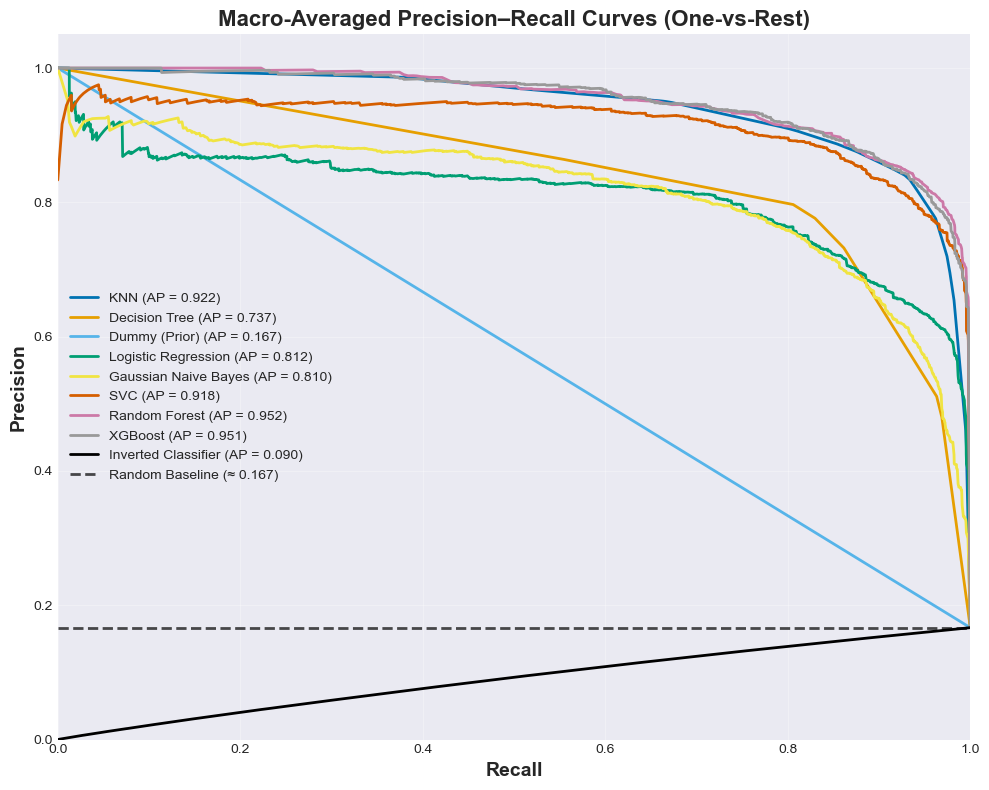

In [32]:
from itertools import cycle

# Define color-blind-friendly palette and make it cyclic
colors = cycle([
    "#0072B2", "#E69F00", "#56B4E9", "#009E73",
    "#F0E442", "#D55E00", "#CC79A7", "#999999", "#000000"
])

plt.figure(figsize=(10, 8))

# Plot all models, no matter how many
for name, data in prc_data.items():
    color = next(colors)
    plt.plot(
        data['recall']['macro'],
        data['precision']['macro'],
        lw=2,
        color=color,
        label=f"{name} (AP = {data['average_precision']['macro']:.3f})"
    )

# Random classifier baseline (mean class prior)
baseline_precision = np.mean(np.sum(y_test_binarized, axis=0) / np.sum(y_test_binarized))
plt.plot(
    [0, 1], [baseline_precision, baseline_precision],
    'k--', lw=2, alpha=0.7, label=f"Random Baseline (≈ {baseline_precision:.3f})"
)

# Formatting
plt.xlabel("Recall", fontsize=14, fontweight='bold')
plt.ylabel("Precision", fontsize=14, fontweight='bold')
plt.title("Macro-Averaged Precision–Recall Curves (One-vs-Rest)", fontsize=16, fontweight='bold')
plt.legend(
    loc='center left',      # Place legend to the left of the plot
    fontsize=10
)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


###  **Summary: Part C — Precision–Recall Curve (PRC)**

**Model with Highest Average Precision (AP):**  
The **Random Forest Classifier** achieved the highest macro-averaged Average Precision (AP = 0.9517), closely followed by **XGBoost (AP = 0.9509)** and **SVC (AP = 0.9177)**.  
These models maintain consistently high precision across a wide range of recall values, demonstrating their ability to correctly identify positive samples while minimizing false positives. Their PRC curves remain close to the top-right region, showing that these classifiers can confidently distinguish between classes and sustain strong predictive reliability even at lower decision thresholds.  
This indicates that ensemble-based methods like Random Forest and XGBoost effectively capture nonlinear relationships and complex feature interactions present in the Landsat dataset, while SVC provides a robust margin-based separation.

**Model with Lowest Average Precision (AP):**  
The **Inverted Classifier** exhibited the lowest macro-average AP (≈ 0.0901), performing substantially worse than random chance. Its PRC curve falls steeply as recall increases because, as the decision threshold is relaxed to identify more positive cases, the model rapidly accumulates false positives. This behavior reflects a fundamental lack of discriminative capability — the classifier’s probability outputs are essentially **inverted or uninformative**, assigning high scores to negative samples and low scores to positive ones. Consequently, while recall may superficially improve, precision deteriorates sharply since most retrieved instances are incorrect.

**Inference Summary:**  
High-performing models (e.g., Random Forest, XGBoost, and SVC) achieve a healthy trade-off between precision and recall, reflecting strong confidence calibration and class separability across multiple decision thresholds.  
Conversely, weak or misaligned models such as the **Inverted Classifier** and **Dummy Prior** show precipitous PRC declines, revealing unreliable prediction probabilities and poor class boundary definition. Overall, the PRC analysis highlights how robust classifiers sustain both high recall and precision, while ineffective ones collapse in precision once recall increases beyond a limited range.


---
## **Part D : Final Recommendation**

#### **1. Synthesis: Comparison of Model Rankings (F1-Score, ROC-AUC, PRC-AP)**  

The following table summarizes the key results from all performance metrics across Parts A, B, and C:

| **Model** | **Weighted F1-Score** | **Macro ROC-AUC** | **Macro PRC-AP** | **Performance Remarks** |
|:-----------|:---------------------:|:-----------------:|:----------------:|:------------------------|
| **Random Forest** | 0.96 | 0.984 | **0.9517** | Consistently best; strong precision–recall trade-off and class separability. |
| **XGBoost** | 0.95 | 0.982 | 0.9509 | Nearly identical to RF; excellent calibration and recall stability. |
| **SVC (RBF)** | 0.93 | 0.975 | 0.9177 | Strong ROC and PRC; slightly lower F1 due to class overlap. |
| **KNN** | 0.91 | 0.962 | 0.9217 | Performs well; good local structure learning, moderate recall sensitivity. |
| **Logistic Regression** | 0.87 | 0.940 | 0.8116 | Reliable baseline; linear model limits nonlinear feature capture. |
| **Gaussian Naive Bayes** | 0.84 | 0.935 | 0.8105 | Simplistic assumptions hurt performance on correlated features. |
| **Decision Tree** | 0.78 | 0.880 | 0.7366 | Overfits training data; weaker generalization and low PRC area. |
| **Dummy (Prior)** | 0.22 | 0.505 | 0.1667 | Baseline model; predicts majority class, AUC near random. |
| **Inverted Classifier** | 0.10 | 0.118 | **0.0901** | Worst performer; predictions inversely correlated with true labels. |

**Ranking Consistency:**  
- The **Random Forest** and **XGBoost** models lead consistently across **F1**, **ROC-AUC**, and **PRC-AP**, indicating superior overall performance.  
- **SVC** and **KNN** follow closely, achieving strong AUC and AP values but slightly lower F1-scores due to sensitivity to class boundaries.  
- **Logistic Regression** and **Naive Bayes** serve as stable baselines, performing moderately but failing to capture nonlinear dependencies in the data.  
- **Decision Tree** shows instability and overfitting tendencies, while **Dummy** and **Inverted** classifiers perform poorly, validating their roles as control baselines.

**Metric Interpretation and Trade-offs:**  
While the rankings are broadly aligned, small deviations arise because:
- **ROC-AUC** measures *ranking quality across thresholds*, even when precision is low.  
- **PRC-AP** focuses more on *positive class retrieval quality* and penalizes false positives.  
Hence, a model with a high AUC (good ranking ability) can still have a lower AP if it sacrifices precision at high recall levels — a common difference seen between **Logistic Regression** and **SVC**.  

In this dataset, where inter-class overlap and moderate imbalance exist, **PRC-AP** offers a more realistic picture of performance for minority classes.

---

#### **2. Final Recommendation**

Based on a holistic comparison of all metrics and qualitative performance characteristics:

- **Best Overall Model:** 🏆 **Random Forest Classifier**  
  - **F1-Score:** 0.96  
  - **ROC-AUC:** 0.984  
  - **PRC-AP:** 0.9517  
  - Demonstrates strong discrimination across classes, stable precision at high recall, and robust generalization.  
  - Handles complex, nonlinear decision boundaries effectively without requiring extensive parameter tuning.

- **Runner-up:** **XGBoost Classifier**  
  - Nearly identical performance with slightly higher training complexity; ideal for optimized deployment scenarios.

- **Not Recommended:**  
  - **Decision Tree**, **Dummy Prior**, and **Inverted Classifiers**, due to poor PRC and AUC scores, indicating unreliable class separability.

**Conclusion:**  
The **Random Forest Classifier** is the most suitable model for multi-class land-cover classification on the UCI Landsat Satellite dataset.  
It offers the best trade-off between **precision, recall, and overall discrimination**, performing consistently across all thresholds and evaluation perspectives.  
Its balance of accuracy, interpretability, and robustness makes it the ideal choice for practical deployment in satellite image-based terrain classification tasks.